In [13]:
import numpy as np
import matplotlib.pyplot as plt
from hamming_distance_distribution import hamming_distance
from annealing import adjacency_from_couplings
from graph import is_connected

In [14]:
def annealing_by_connection(blocksize, fname):

    # read data from file
    data = np.load(fname, allow_pickle=True).item()

    N_blocks = int(data['size']/blocksize)
    N_correct_connected     = np.zeros(N_blocks)
    N_correct_unconnected   = np.zeros(N_blocks)
    N_connected             = np.zeros(N_blocks)
    N_unconnected           = np.zeros(N_blocks)

    for j in range(N_blocks):

        for i in range(blocksize):
            # get annealing results
            J_n         = data["J_n"][j*blocksize + i]
            alpha       = data["alpha"][j*blocksize + i]
            gs_array1   = data["gs_array"][j*blocksize + i]
      
            # classify annealing result
            d_Hamming = hamming_distance(alpha, gs_array1)
            connected = is_connected(adjacency_from_couplings(J_n))

            if connected:
                N_connected[j] += 1
                if d_Hamming==0:
                    N_correct_connected[j] += 1

            if not connected:
                N_unconnected[j] += 1
                if d_Hamming==0:
                    N_correct_unconnected[j] += 1

    return N_correct_connected, N_correct_unconnected, N_connected, N_unconnected


In [15]:
# ---------- Parameters for reading data file -------------
paths = ["./annealing_data/", "./exhaustive_search_data/"]
path = paths[1]

N = 5               # number of users
M = 4               # length of id-sequence for every user
K = 100              # number of antennas
xi = 0              # std of thermal noise

thres_min = 0.0         # rule=1: 0.0
thres_max = 15         # rule=1: 0.4
thres_step = 1       # rule=1: 0.01
neglection_rule = 2

blocksize = 100       # resolution of y axis (equal to N_repeat from other program)

In [16]:
path += f"rule_{neglection_rule}/"

# ---------- Program ----------
thres_min = float(thres_min)
thres_max = float(thres_max)

N_neglection_thres = int((thres_max-thres_min)/thres_step)+1
data = np.load(path + f"neglection_thres_{thres_min}_N_5_M_4_K_100_xi_0.npy", allow_pickle=True).item()

N_blocks = int(data["size"]/blocksize)
print(f"file includes {data['size']} runs which get split into {N_blocks} blocks of size {blocksize}.")
N_stat = N_blocks

N_correct_connected     = np.zeros(shape=(N_neglection_thres, N_stat))
N_correct_unconnected   = np.zeros(shape=(N_neglection_thres, N_stat))
N_connected             = np.zeros(shape=(N_neglection_thres, N_stat))
N_unconnected           = np.zeros(shape=(N_neglection_thres, N_stat))

neglection_thres = np.zeros(N_neglection_thres)

for i in range(N_neglection_thres):
    neglection_thres[i] = thres_min + i*thres_step
    neglection_thres[i] = np.round(neglection_thres[i], 6)

    fname = path + f"neglection_thres_{neglection_thres[i]}_N_{N}_M_{M}_K_{K}_xi_{xi}.npy"
    print(f"{i}: {fname}")
    result = annealing_by_connection(blocksize, fname)

    N_correct_connected[i]      = result[0]
    N_correct_unconnected[i]    = result[1]
    N_connected[i]              = result[2]
    N_unconnected[i]            = result[3]


file includes 110000 runs which get split into 1100 blocks of size 100.
0: ./exhaustive_search_data/rule_2/neglection_thres_0.0_N_5_M_4_K_100_xi_0.npy
1: ./exhaustive_search_data/rule_2/neglection_thres_1.0_N_5_M_4_K_100_xi_0.npy
2: ./exhaustive_search_data/rule_2/neglection_thres_2.0_N_5_M_4_K_100_xi_0.npy
3: ./exhaustive_search_data/rule_2/neglection_thres_3.0_N_5_M_4_K_100_xi_0.npy
4: ./exhaustive_search_data/rule_2/neglection_thres_4.0_N_5_M_4_K_100_xi_0.npy
5: ./exhaustive_search_data/rule_2/neglection_thres_5.0_N_5_M_4_K_100_xi_0.npy
6: ./exhaustive_search_data/rule_2/neglection_thres_6.0_N_5_M_4_K_100_xi_0.npy
7: ./exhaustive_search_data/rule_2/neglection_thres_7.0_N_5_M_4_K_100_xi_0.npy
8: ./exhaustive_search_data/rule_2/neglection_thres_8.0_N_5_M_4_K_100_xi_0.npy
9: ./exhaustive_search_data/rule_2/neglection_thres_9.0_N_5_M_4_K_100_xi_0.npy
10: ./exhaustive_search_data/rule_2/neglection_thres_10.0_N_5_M_4_K_100_xi_0.npy
11: ./exhaustive_search_data/rule_2/neglection_thres_11.0

In [17]:
# ratios
if len(np.where(N_connected==0)[0])>0:
    print(f"Division by zero: N_connected   = 0 at {np.where(N_connected==0)}")
if len(np.where(N_unconnected==0)[0])>0:
    print(f"Division by zero: N_unconnected = 0 at {np.where(N_unconnected==0)}")

r_correct_connected     = N_correct_connected   /   N_connected
r_correct_unconnected   = N_correct_unconnected /   N_unconnected

Division by zero: N_connected   = 0 at (array([ 7,  7,  7, ..., 15, 15, 15]), array([   0,    1,    2, ..., 1097, 1098, 1099]))
Division by zero: N_unconnected = 0 at (array([0, 0, 0, ..., 3, 3, 3]), array([   0,    1,    2, ..., 1097, 1098, 1099]))


/tmp/ipykernel_18242/3773222365.py:7: RuntimeWarning: invalid value encountered in divide
  r_correct_connected     = N_correct_connected   /   N_connected
/tmp/ipykernel_18242/3773222365.py:8: RuntimeWarning: invalid value encountered in divide
  r_correct_unconnected   = N_correct_unconnected /   N_unconnected


In [18]:
# statistics
r_correct_connected_mean    = np.mean(r_correct_connected, axis=1)
dr_correct_connected        = np.std(r_correct_connected, axis=1)
dr_mean_correct_connected   = dr_correct_connected / np.sqrt(N_stat)

r_correct_unconnected_mean  = np.mean(r_correct_unconnected, axis=1)
dr_correct_unconnected      = np.std(r_correct_unconnected, axis=1)
dr_mean_correct_unconnected = dr_correct_unconnected / np.sqrt(N_stat)

total number of runs per neglection threshold: 100
obtained ratios:
correct connected: 
[0.99141818 0.98925455 0.98557273 0.97915455 0.96983531 0.95519686
 0.9359076         nan        nan        nan        nan        nan
        nan        nan        nan        nan] +- [0.00027452 0.00030286 0.00036197 0.00041472 0.00053586 0.00069584
 0.00109013        nan        nan        nan        nan        nan
        nan        nan        nan        nan], 
unconnected: 
[       nan        nan        nan        nan 0.95556588 0.90793365
 0.90618723 0.8782     0.81170909 0.73379091 0.55178182 0.54662727
 0.55058182 0.54894545 0.54882727 0.54866364] +- [       nan        nan        nan        nan 0.09340238 0.06922728
 0.03997576 0.03209696 0.03911971 0.04573532 0.05083402 0.04953408
 0.0498108  0.04998342 0.05024474 0.0491892 ]


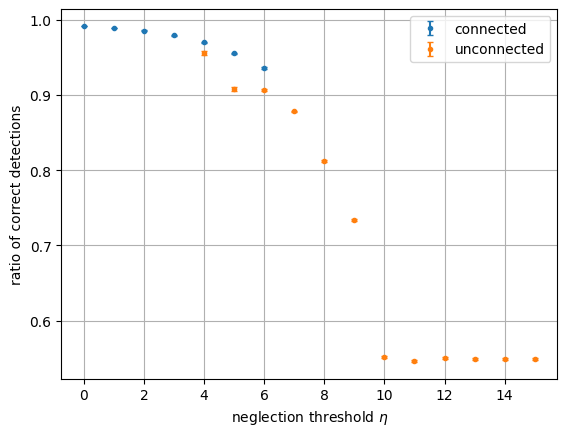

In [19]:
# Results

print(f"total number of runs per neglection threshold: {blocksize}")
print("obtained ratios:")
print(f"correct connected: \n{r_correct_connected_mean} +- {dr_mean_correct_connected}, \nunconnected: \n{r_correct_unconnected_mean} +- {dr_correct_unconnected}")

# Plotting
plt.errorbar(x=neglection_thres, y=r_correct_connected_mean, yerr=dr_mean_correct_connected, label="connected", capsize=2, ls="none", marker=".")
plt.errorbar(x=neglection_thres, y=r_correct_unconnected_mean, yerr=dr_mean_correct_unconnected, label="unconnected", capsize=2, ls="none", marker=".")
plt.xlabel(r"neglection threshold $\eta$")
plt.ylabel("ratio of correct detections")
plt.legend()
plt.grid()
plt.show()

UER = 1 - r


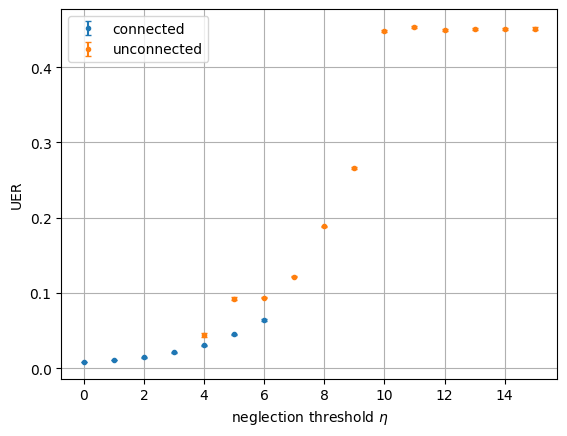

In [20]:
# use the same data but show it in a different fashion: The user error rate
print(f"UER = 1 - r")
# Plotting
plt.errorbar(x=neglection_thres, y=1-r_correct_connected_mean, yerr=dr_mean_correct_connected, label="connected", capsize=2, ls="none", marker=".")
plt.errorbar(x=neglection_thres, y=1-r_correct_unconnected_mean, yerr=dr_mean_correct_unconnected, label="unconnected", capsize=2, ls="none", marker=".")
plt.xlabel(r"neglection threshold $\eta$")
plt.ylabel("UER")
plt.legend()
plt.grid()
plt.show()